[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cadCAD-org/demos/blob/master/tutorials/robots_and_marbles/robot-marbles-part-4/robot-marbles-part-4.ipynb)

# cadCAD Tutorials: The Robot and the Marbles, part 4
In parts [1](../robot-marbles-part-1/robot-marbles-part-1.ipynb) and [2](../robot-marbles-part-2/robot-marbles-part-2.ipynb) we introduced the 'language' in which a system must be described in order for it to be interpretable by cadCAD and some of the basic concepts of the library:
* State Variables
* Timestep
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters
* Policies

In [part 3](../robot-marbles-part-3/robot-marbles-part-3.ipynb) we covered how to describe the presence of asynchronous subsystems within the system being modeled in cadCAD.

So far, all the examples referred to deterministic systems: no matter how many times you ran one of those simulations, the results would be the same. However, systems are more commonly non-deterministic, and modelling them as deterministic might be an oversimplification sometimes. 

In this notebook, we'll cover cadCAD's support for modelling non-deterministic systems and Monte Carlo simulations. But first let's copy the base configuration with which we ended Part 3. Here's the description of that system:

__The robot and the marbles__  
* Picture a box (`box_A`) with ten marbles in it; an empty box (`box_B`) next to the first one; and __two__ robot arms capable of taking a marble from any one of the boxes and dropping it into the other one. 
* The robots are programmed to take one marble at a time from the box containing the largest number of marbles and drop it in the other box. They repeat that process until the boxes contain an equal number of marbles.
* The robots act __asynchronously__; robot 1 acts once every two timesteps, and robot 2 acts once every three timesteps.

In [1]:
%%capture
# Only run this cell if you need to install the libraries
# If running in google colab, this is needed.

!pip install cadcad matplotlib pandas numpy

In [2]:
# Import dependancies

# Data processing and plotting libraries
import pandas as pd
import numpy as np
from random import normalvariate
import matplotlib.pyplot as plt

# cadCAD specific libraries
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionContext, Executor

In [3]:
def p_robot_arm(params, substep, state_history, previous_state):
    
    # Parameters & variables
    box_a = previous_state['box_A']
    box_b = previous_state['box_B']
    
    # Logic
    if box_b > box_a:
        b_to_a = 1
    elif box_b < box_a:
        b_to_a = -1
    else:
        b_to_a = 0
    
    # Output
    return({'add_to_A': b_to_a, 'add_to_B': -b_to_a})

In [4]:
robots_periods = [2,3] # Robot 1 acts once every 2 timesteps; Robot 2 acts once every 3 timesteps

def get_current_timestep(cur_substep, previous_state):
    if cur_substep == 1:
        return previous_state['timestep']+1
    return previous_state['timestep']

def robot_arm_1(params, substep, state_history, previous_state):
    _robotId = 1
    if get_current_timestep(substep, previous_state)%robots_periods[_robotId-1]==0: # on timesteps that are multiple of 2, Robot 1 acts
        return p_robot_arm(params, substep, state_history, previous_state)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # for all other timesteps, Robot 1 doesn't interfere with the system

def robot_arm_2(params, substep, state_history, previous_state):
    _robotId = 2
    if get_current_timestep(substep, previous_state)%robots_periods[_robotId-1]==0: # on timesteps that are multiple of 3, Robot 2 acts
        return p_robot_arm(params, substep, state_history, previous_state)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # for all other timesteps, Robot 1 doesn't interfere with the system

In [5]:
def s_box_A(params, substep, state_history,  previous_state, policy_input):
    # Parameters & variables
    box_A_current = previous_state['box_A']
    box_A_change = policy_input['add_to_A']
   
    # Logic
    box_A_new = box_A_current + box_A_change
    
    # Output
    return ('box_A', box_A_new)
    
def s_box_B(params, substep, state_history,  previous_state, policy_input):
    # Parameters & variables
    box_B_current = previous_state['box_B']
    box_B_change = policy_input['add_to_B']

    # Logic
    box_B_new = box_B_current + box_B_change
    
    # Output
    return ('box_B', box_B_new)

In [6]:
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robot_arm_1': robot_arm_1,
            'robot_arm_2': robot_arm_2
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': s_box_A,
            'box_B': s_box_B
        }
    }
]

In [7]:
initial_state = {
    'box_A': 10, # box_A starts out with 10 marbles in it
    'box_B': 0 # box_B starts out empty
}

In [8]:
MONTE_CARLO_RUNS = 1
SIMULATION_TIMESTEPS = 10

sim_config = config_sim(
    {
        'N': MONTE_CARLO_RUNS,
        'T': range(SIMULATION_TIMESTEPS),
        #'M': {} # This will be explained in later tutorials
    }
)

In [9]:
from cadCAD import configs
del configs[:]

experiment = Experiment()

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=configs)

(system_events, tensor_field, sessions) = run.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 1, 1, 2)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.01s


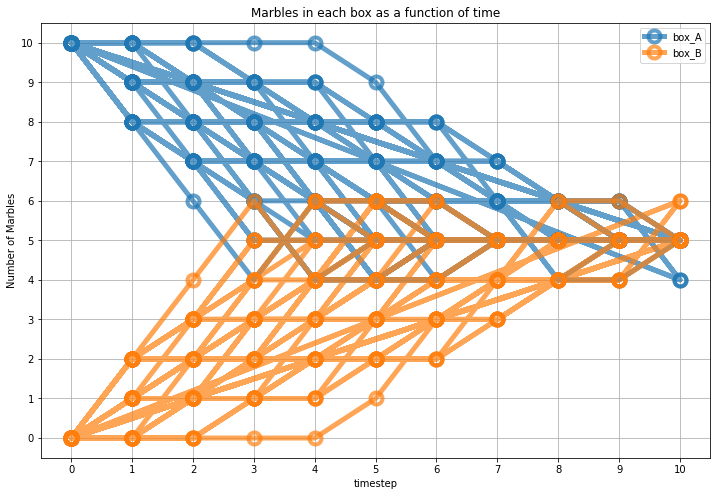

In [25]:
df = pd.DataFrame(system_events)
# Create figure
fig = df.plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                markeredgewidth=4, alpha=0.7, markerfacecolor='black',
                linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                ylabel='Number of Marbles', grid=True, fillstyle='none',  
                xticks=list(df['timestep'].drop_duplicates()),
                yticks=list(range(1+(df['box_A']+df['box_B']).max())));

# Non-determinism
Non-deterministic systems exhibit different behaviors on different runs for the same input. The order of heads and tails in a series of 3 coin tosses, for example, is non deterministic. 

Our robots and marbles system is currently modelled as a deterministic system. Meaning that every time we run the simulation: none of the robots act on timestep 1; robot 1 acts on timestep 2; robot 2 acts on timestep 3; an so on. 

If however we were to define that at every timestep each robot would act with a probability P, then we would have a non-deterministic (probabilistic) system. Let's make the following changes to our system.
* Robot 1: instead of acting once every two timesteps, there's a 50% chance it will act in any given timestep
* Robot 2: instead of acting once every three timesteps, there's a 33.33% chance it will act in any given timestep

In [11]:
from random import random as rand

# We specify each of the robots logic in a Policy Function
robots_probabilities = [0.5,1/3] # Robot 1 acts with a 50% probability; Robot 2, 33.33%

def robot_arm_1(params, substep, state_history, previous_state):
    _robotId = 1
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return p_robot_arm(params, substep, state_history, previous_state)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # for all other timesteps, Robot 1 doesn't interfere with the system

def robot_arm_2(params, substep, state_history, previous_state):
    _robotId = 2
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return p_robot_arm(params, substep, state_history, previous_state)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # for all other timesteps, Robot 1 doesn't interfere with the system

In the Partial State Update Blocks, the user specifies if state update functions will be run in series or in parallel and the policy functions that will be evaluated in that block

In [12]:
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robot_arm_1': robot_arm_1,
            'robot_arm_2': robot_arm_2
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': s_box_A,
            'box_B': s_box_B
        }
    }
]

If we run the simulation with those configurations, the system is unlikely to exhibit the same behavior as it did in its deterministic version

In [13]:
from cadCAD import configs
del configs[:]

experiment = Experiment()

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=configs)

(system_events, tensor_field, sessions) = run.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 1, 1, 2)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.01s


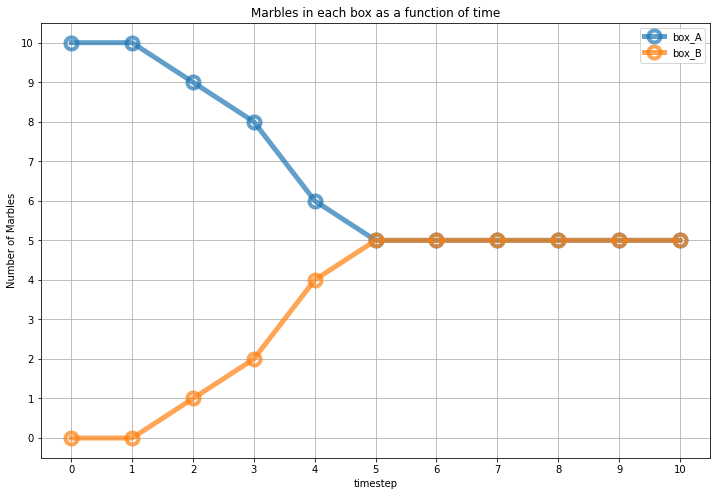

In [14]:
df = pd.DataFrame(system_events)
# Create figure
fig = df.plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                markeredgewidth=4, alpha=0.7, markerfacecolor='black',
                linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                ylabel='Number of Marbles', grid=True, fillstyle='none',  
                xticks=list(df['timestep'].drop_duplicates()),
                yticks=list(range(1+(df['box_A']+df['box_B']).max())));

And if we run it again, it returns yet another result

In [15]:
del configs[:]

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

run = Executor(exec_context=exec_context, configs=configs)

(system_events, tensor_field, sessions) = run.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 1, 1, 2)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [1]
Execution Mode: single_threaded
Total execution time: 0.01s


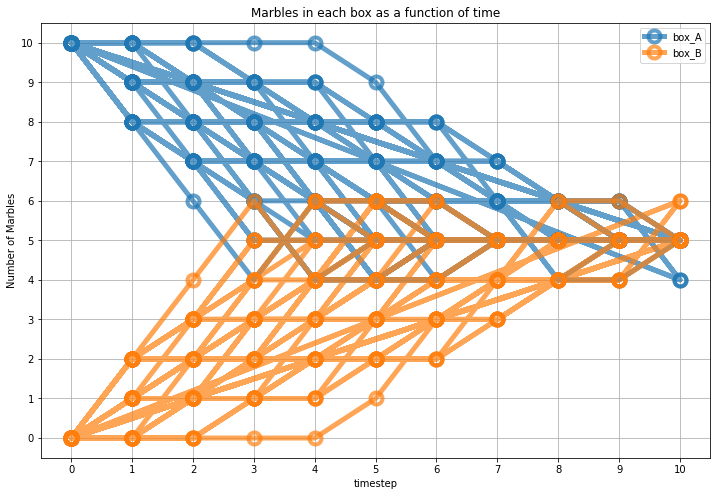

In [21]:
df = pd.DataFrame(system_events)
# Create figure
fig = df.plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                markeredgewidth=4, alpha=0.7, markerfacecolor='black',
                linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                ylabel='Number of Marbles', grid=True, fillstyle='none',  
                xticks=list(df['timestep'].drop_duplicates()),
                yticks=list(range(1+(df['box_A']+df['box_B']).max())));

## Monte Carlo Simulations

In order to take advantage of cadCAD's Monte Carlo simulation features, we should modify the configuration file so as to define the number of times we want the same simulation to be run. This is done in the `N` key of the `sim_config` dict.

Settings of general simulation parameters, unrelated to the system itself

* `N` is the number of times the simulation will be run (Monte Carlo runs)
* `T` is a range with the number of discrete units of time the simulation will run for
* `M` will be explained in a future article

In [17]:
MONTE_CARLO_RUNS = 50

sim_config = config_sim(
    {
        'N': MONTE_CARLO_RUNS,
        'T': range(SIMULATION_TIMESTEPS),
        #'M': {} # This will be explained in later tutorials
    }
)

del configs[:]

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

run = Executor(exec_context=exec_context, configs=configs)

(system_events, tensor_field, sessions) = run.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 1, 50, 2)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
ExpIDs   : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [18]:
df = pd.DataFrame(system_events)

df.set_index(['simulation', 'run', 'timestep', 'substep'])

box_A  box_B  subset
simulation run timestep substep                      
0          1   0        0           10      0       0
               1        1            9      1       0
               2        1            8      2       0
               3        1            8      2       0
               4        1            7      3       0
...                                ...    ...     ...
           50  6        1            5      5       0
               7        1            5      5       0
               8        1            5      5       0
               9        1            5      5       0
               10       1            5      5       0

[550 rows x 3 columns]

Plotting two of those runs allows us to see the different behaviors over time.

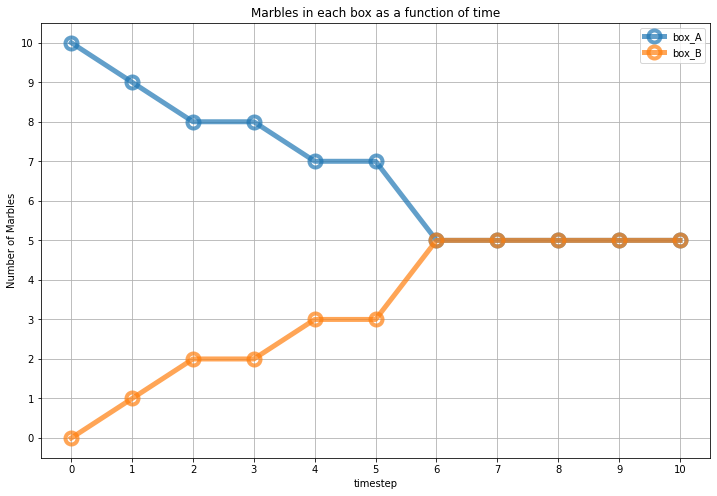

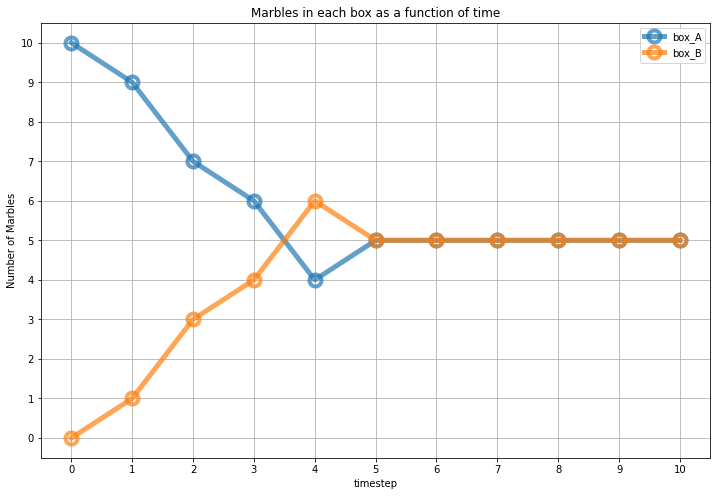

In [28]:
df[df['run']==1].plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                markeredgewidth=4, alpha=0.7, markerfacecolor='black',
                linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                ylabel='Number of Marbles', grid=True, fillstyle='none',  
                xticks=list(df['timestep'].drop_duplicates()),
                yticks=list(range(1+(df['box_A']+df['box_B']).max())));

df[df['run']==9].plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                markeredgewidth=4, alpha=0.7, markerfacecolor='black',
                linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                ylabel='Number of Marbles', grid=True, fillstyle='none',  
                xticks=list(df['timestep'].drop_duplicates()),
                yticks=list(range(1+(df['box_A']+df['box_B']).max())));

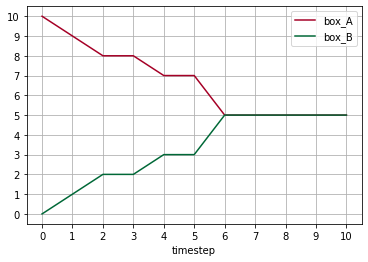

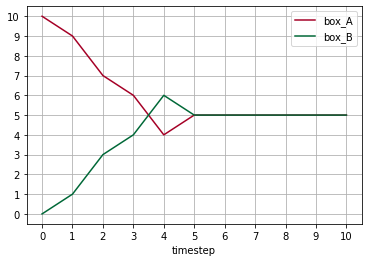

In [19]:
df[df['run']==1].plot('timestep', ['box_A', 'box_B'], grid=True,
                          xticks=list(df['timestep'].drop_duplicates()), 
                          yticks=list(range(11)),
                          colormap = 'RdYlGn');

df[df['run']==9].plot('timestep', ['box_A', 'box_B'], grid=True,
                            xticks=list(df['timestep'].drop_duplicates()), 
                            yticks=list(range(11)),
                            colormap = 'RdYlGn');

If we plot all those runs onto a single chart, we can see every possible trajectory for the number of marbles in each box.

In [20]:
ax = None
for i in range(0,mc):
    ax = df[df['run']==i+1].plot('timestep', ['box_A', 'box_B'],
                                     grid=True,
                                     xticks=list(df['timestep'].drop_duplicates()), 
                                     yticks=list(range(1+max(df['box_A'].max(),df['box_B'].max()))),
                                     legend = (ax == None),
                                     colormap = 'RdYlGn',
                                     ax = ax
                                  )

NameError: name 'mc' is not defined

For some analyses, it might make sense to look at the data in aggregate. Take the median for example:

In [ ]:
dfmc_median = df.groupby(['timestep', 'substep']).median().reset_index()
dfmc_median.plot('timestep', ['box_A', 'box_B'], 
                 grid=True,
                 xticks=list(dfmc_median['timestep'].drop_duplicates()), 
                 yticks=list(range(int(1+max(dfmc_median['box_A'].max(),dfmc_median['box_B'].max())))),
                 colormap = 'RdYlGn'
                )

Or look at edge cases

In [ ]:
max_final_A = df[df['timestep']==df['timestep'].max()]['box_A'].max()
# max_final_A
slow_runs = df[(df['timestep']==df['timestep'].max()) & 
         (df['box_A']==max_final_A)]['run']
slow_runs = list(slow_runs)
slow_runs

ax = None
for i in slow_runs:
    ax = df[df['run']==i].plot('timestep', ['box_A', 'box_B'],
                                     grid=True,
                                     xticks=list(df['timestep'].drop_duplicates()), 
                                     yticks=list(range(1+max(df['box_A'].max(),df['box_B'].max()))),
                                     legend = (ax == None),
                                     colormap = 'RdYlGn',
                                     ax = ax
                                  )

We invite the reader to fork this code and come up with answers for their other questions that might be interesting to look at. For example:
* How often does box B momentarily contain more marbles than box A?
* What's the frequency distribution of the time to reach equilibrium?
* What's the probability distribution of the waiting times of each one of the robots?